In [51]:
import os
import shutil
from pathlib import Path
import pandas as pd
import numpy as np
from scipy.fftpack import fft
import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

import plotly.express as px
# import plotly.graph_objects as go

def clean_pge_df_ts(csv_path, year=None):
    ''' 
    Extract and clean PG&E time-series
    :csv_path: path to the raw PG&E time series CSV
    '''
    # Return the normalized value
    df_t = pd.read_csv(csv_path, parse_dates=True)
    if year != None:
        df_t['Datetime'] = pd.to_datetime(df_t['Datetime'])
        df_t = df_t[df_t['Datetime'].dt.year == year]
        if len(df_t.index) == 0: return df_t
    
    df_t = df_t.set_index(pd.DatetimeIndex(df_t['Datetime']))
    df_t = df_t.drop(columns =['Datetime'])
    df_t = normalize_df_col(df_t, 'Value')
    df_t['date'] = pd.DatetimeIndex(df_t.index).date
    return df_t

# Function to normalize a numeric df column
def normalize_df_col(df, colname, scale_min=0, scale_max=1):
    '''
    Normalize a column of a dataframe to (scale_min, scale_max)
    '''
    arr_values = df[colname].values.reshape((len(df.index), 1))
    scaler = MinMaxScaler(feature_range=(scale_min, scale_max))
    scaler = scaler.fit(arr_values)
    arr_normalized = scaler.transform(arr_values)
    df[colname] = arr_normalized
    return df

def get_fft_values(y_values, T, N, f_s, window=1):
    '''
    Get the frequency and amplitude values
    :param y_values: the time domain y-values
    :param T: period
    :param N: number of data points
    :param f_s: sample frequency
    :return: [frequencies (frequency domain x values)] and [amplitudes (frequency domain x values)]
    '''
    window = np.hanning(len(y_values)) 
    f_values = np.linspace(0.0, 1.0/(2.0*T), N//2) # Frequency values (x-axix in the frequency domain)
    fft_values_ = fft(y_values*window) # Real part: amplitude of the signal, Imaginary part: phase of the signal
    fft_values = 2.0/N * np.abs(fft_values_[0:N//2]) # np.abs: get the real part, N//2: Only need the positive part of the result
    return f_values, fft_values

def get_load_fft(df_t, sample_timestep=15):
    '''
    Get the frequency and amplitude values from a time-series dataframe. 
    :param df_t: dataframe with a 'Value' column
    :param sample_timestep: minutes per timestep
    :return: frequency and amplitude values arrays
    '''
    t_n = len(df_t['Value']) * sample_timestep * 60    # Total duration of sample (seconds)
    N = len(df_t['Value'])                             # Total number of sample points
    T = t_n / N                                        # Timestep (seconds)
    f_s = 1/T                                          # Sample frequency (Hz)
    y_values = df_t['Value'].tolist()
    f_values, fft_values = get_fft_values(y_values, T, N, f_s)
    return f_values, fft_values

def get_fft_sum_by_bins(f_values, fft_values, hour_interval_bins):
    ''' 
    Create bins of amplitude sums by hour intervals
    :param f_values: frequency values
    :param fft_values: corresponding amplitude values
    :param hour_interval_bins: a list of hour intervals e.g., [[0.5, 1], [1, 2], [2, 4]]
    :return: a pandas dataframe where each column is the bin name and rows are sum of the amplitude
    '''
    hour_to_sec = 3600
    sec_interval_bins = [[interval_l*hour_to_sec, interval_h*hour_to_sec] for [interval_l, interval_h] in hour_interval_bins]
    hz_freq_bins = [[1/interval_h, 1/interval_l] for [interval_l, interval_h] in sec_interval_bins]
    col_names = [f"{interval_l}hr ~ {interval_h}hr" for [interval_l, interval_h] in hour_interval_bins]
    sum_hz_bins = []
    for i, bounds in enumerate(hz_freq_bins):
        hz_req_l, hz_req_h = bounds
        temp_sum = 0
        for j, hz_value in enumerate(f_values):
            if hz_value>hz_req_l and hz_value<=hz_req_h:
                temp_sum += fft_values[j]
        sum_hz_bins.append(temp_sum)
    df_sum_bins = pd.DataFrame([sum_hz_bins], columns = col_names)
    return df_sum_bins



def generate_ts_html(df_t, str_title, dir_save):
    fig = px.line(df_t, x=df_t.index, y='Value', range_x=['2015-01-01','2015-12-31'])
    fig.update_layout(
        title={
            'text': f"Normalized consumption for {str_title}",
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
        xaxis_title="Datetime",
        yaxis_title="Value",
    )
    fig.update_xaxes(rangeslider_visible=True)
    fig.write_html(f"{dir_save}/{str_title}.html")

In [45]:
dir_c_drive = "/mnt/c/"  # For use in WSL
dir_ts_CSVs = os.path.join(dir_c_drive, 'Users/hlee9/Documents/projects/DOE_EULP/PGE_study/stage_1/ts_CSVs/cluster_1')
v_ts_CSVs = [os.path.join(dir_ts_CSVs, dir_csv) for dir_csv in os.listdir(dir_ts_CSVs)]

hour_interval_bins = [
    [0.5, 1],
    [1, 2],
    [2, 4],
    [4, 8],
    [8, 12],
    [12, 24],
    [24, 168],
#     [168, 9999999],
]


v_valid_ts_csv = []
for i, ts_csv in enumerate(v_ts_CSVs):
    sp_id = os.path.basename(ts_csv).split('.')[0]
    try:
        df_ts = clean_pge_df_ts(ts_csv, 2015).dropna()
        f_values, fft_values = get_load_fft(df_ts)
        df = get_fft_sum_by_bins(f_values, fft_values, hour_interval_bins)
#         dir_csv = os.path.join(dir_results, f"{sp_id}_annual_fft_bins.csv")
#         df.to_csv(dir_csv, index=False)
        if i == 0:
            df_all = df
        else:
            df_all = df_all.append(df)
        v_valid_ts_csv.append(ts_csv)
    except:
        pass

len(v_valid_ts_csv)
# plt.plot(df_all.iloc[0:150, :].to_numpy().T)

186

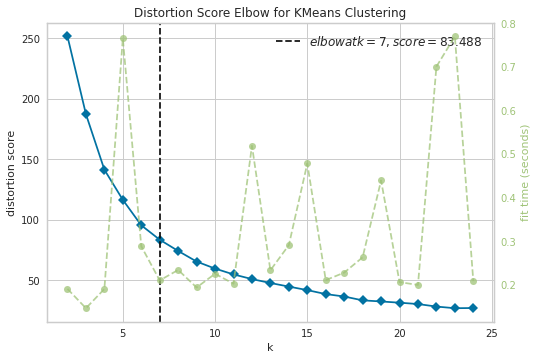

In [47]:
# Select n
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,25))
visualizer.fit(fft_data)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure


In [48]:
# Actual clustering
standard_feature = True
standard_feature = False
scaler = preprocessing.StandardScaler()
if standard_feature:
    fft_data = scaler.fit_transform(df_all)
else:
    fft_data = df_all.to_numpy()

kmeans = KMeans(n_clusters=7, init='random', n_init=3)
KM_model = kmeans.fit(fft_data)
kmeans.fit_predict(fft_data)

kmeans_labels = kmeans.labels_
kmeans_labels.shape


(186,)

In [52]:
# import shutil
cluster_out_dir = os.path.join(dir_c_drive, 'Users/hlee9/Documents/projects/DOE_EULP/PGE_study/stage_2/annual_fft_clustering')
dir_stage_1_ts_heatmaps = os.path.join(dir_c_drive, 'Users/hlee9/Documents/projects/DOE_EULP/PGE_study/stage_1/ts_heatmaps/cluster_1')
ts_heatmaps = {
    os.path.basename(img_name).split('.')[0]: 
    os.path.join(dir_stage_1_ts_heatmaps, img_name) for img_name in os.listdir(dir_stage_1_ts_heatmaps) if img_name.endswith('png')
}

dir_stage_1_ts_lines = os.path.join(dir_c_drive, 'Users/hlee9/Documents/projects/DOE_EULP/PGE_study/ts_heatmaps')
ts_lines = {
    os.path.basename(img_name).split('.')[0]: 
    os.path.join(dir_stage_1_ts_lines, img_name) for img_name in os.listdir(dir_stage_1_ts_lines) if img_name.endswith('html')
}

ts_heatmaps
for i, label in enumerate(kmeans_labels):
    cluster_dir = os.path.join(cluster_out_dir, f"cluster_{label}")
    if not os.path.exists(cluster_dir):
        os.mkdir(cluster_dir)
    sp_id = os.path.basename(v_valid_ts_csv[i]).split('.')[0]
    
    # Move ts-line plots
    shutil.copy(ts_heatmaps[sp_id], cluster_dir)    
    # move ts-heatmaps
    shutil.copy(ts_lines[sp_id], cluster_dir)

KeyError: '2501872105'